In [1]:
import os
import re
import sys
import glob

import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import librosa
import torchlibrosa
from torchlibrosa.stft import LogmelFilterBank, Spectrogram
from torchlibrosa.augmentation import SpecAugmentation
import kornia
from kornia.enhance.normalize import Normalize
import audiomentations as audio
import albumentations as album

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append("../src")
import const
from utils import DataHandler

In [2]:
dh = DataHandler()

In [3]:
train_df = pd.read_csv('../data/input/train_metadata.csv')
valid_df = pd.read_csv('../data/input/train_soundscape_labels.csv')
train_noise = dh.load('../data/processed/train_noise.json')

use_idx = valid_df[~valid_df["audio_id"].isin([7019, 7954, 14473])].index
drop_idx = valid_df[valid_df["audio_id"].isin([7019, 7954, 14473])].index
valid_df = valid_df.iloc[use_idx].reset_index(drop=True)

In [4]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V


def minmax(images):
    min_images = images.min(-2, keepdim=True)[0]
    min_images = min_images.min(-1, keepdim=True)[0]
    
    max_images = images.max(-2, keepdim=True)[0]
    max_images = max_images.max(-1, keepdim=True)[0]
    
    norm_images = ((images - min_images) / (max_images - min_images + 1e-5))

    return norm_images


def wave2mel(wave, mel_type, spec=False):
    if mel_type == "torchlibrosa":
        feature_extractor = torch.nn.Sequential(
            Spectrogram(
                n_fft=1024,
                hop_length=512,
                win_length=None,
                window="hann",
                center=True,
                pad_mode="reflect",
                power=2.0,
                freeze_parameters=True,
            ),
            LogmelFilterBank(
                sr=32_000,
                n_fft=1024,
                n_mels=128,
                fmin=20,
                fmax=16_000,
                is_log=True,
                ref=1.0,
                amin=1e-10,
                top_db=80.0,
                freeze_parameters=True,
            )
        )
        wave_cuda = torch.FloatTensor(wave.reshape(1, -1)).cuda()
        feature_extractor = feature_extractor.cuda()
        mel = feature_extractor(wave_cuda)
        if spec:
            spec_augmenter = SpecAugmentation(
                time_drop_width=8,
                time_stripes_num=12,
                freq_drop_width=8,
                freq_stripes_num=0,
            )
            mel = spec_augmenter(mel)
        mel = mel.transpose(2, 3)
        
#         mel = mel.transpose(1, 3)
#         bn0 = nn.BatchNorm2d(256).cuda()
#         mel = bn0(mel)
#         mel = mel.transpose(1, 3)

        mel = torch.squeeze(mel)
        mel = minmax(mel)
        mel_numpy = mel.cpu().detach().numpy()
    
    elif mel_type == "librosa":
        melspec = librosa.feature.melspectrogram(
            wave,
            sr=32_000,
            n_fft=2048,
            n_mels=128,
            hop_length=512,
            win_length=None,
            fmin=20,
            fmax=16_000,
            window="hann",
            center=True,
            pad_mode="reflect",
            power=2.0,
            htk=False,
            norm='slaney',
        )
        melspec = librosa.power_to_db(
            melspec,
            ref=1.0,
            amin=1e-10,
            top_db=80.0
        ).astype(np.float32)
        mel_numpy = mono_to_color(melspec)    
    
    return mel_numpy


def get_valid_mel(idx, transform=False, spec=False):
    site = valid_df.loc[idx, "site"]
    audio_id = valid_df.loc[idx, "audio_id"]
    seconds = valid_df.loc[idx, "seconds"]

    path = glob.glob(f"../data/input/train_soundscapes/{audio_id}*")[0]
    y, sr = librosa.load(path, sr=const.TARGET_SAMPLE_RATE)
    
    s = sr * (seconds - 5)
    e = sr * seconds
    
    y_ = y[s: e]
    
#     rms = np.sqrt(np.mean(np.square(y_), axis=-1))
    
    if transform:
        audio_transforms = audio.Compose([
            audio.Gain(p=1.0),
#             audio.Shift(p=1.0),
#             audio.AddGaussianSNR(p=1.0)
        ])
        y_ = audio_transforms(
            samples=y_,
            sample_rate=const.TARGET_SAMPLE_RATE
        )

    img_torchlibrosa = wave2mel(y_, "torchlibrosa", spec=spec)
    img_librosa = wave2mel(y_, "librosa")

    return img_torchlibrosa, img_librosa

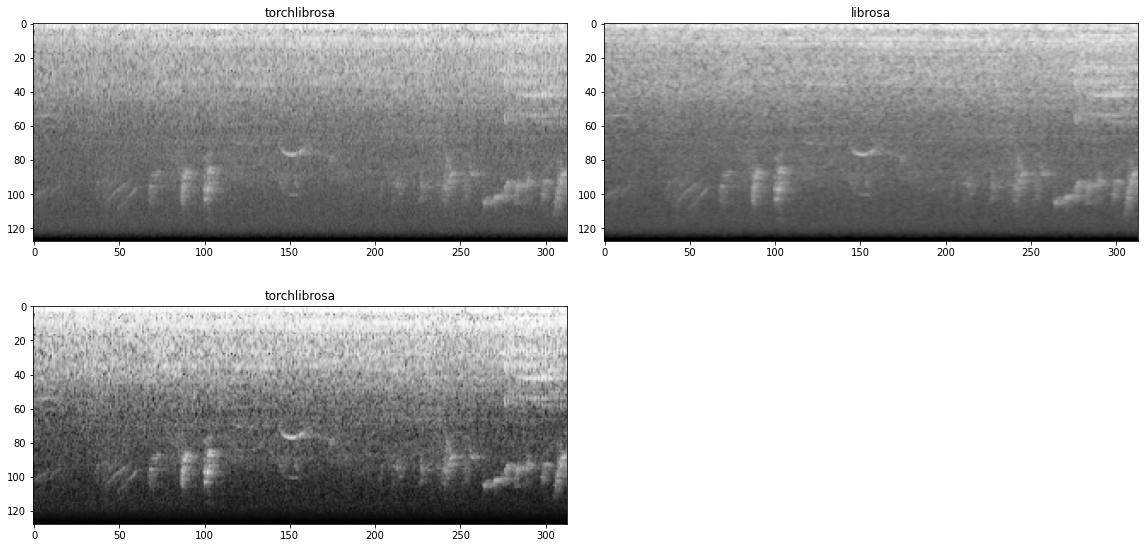

In [5]:
idx = 240
img_torchlibrosa, img_librosa = get_valid_mel(idx)

plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.imshow(img_torchlibrosa, cmap="gray")
plt.title("torchlibrosa")


plt.subplot(2, 2, 2)
plt.imshow(img_librosa, cmap="gray")
plt.title("librosa")


transform = album.Compose([
#     album.RandomBrightness(p=1.0),
    album.CLAHE(p=1.0, clip_limit=3, tile_grid_size=(4, 1))
])
img_torchlibrosa_ = ((img_torchlibrosa - img_torchlibrosa.min()) / (img_torchlibrosa.max() - img_torchlibrosa.min()) * 255).astype(np.uint8)
img_torchlibrosa_ = transform(image=img_torchlibrosa_)["image"]
plt.subplot(2, 2, 3)
plt.imshow(img_torchlibrosa_, cmap="gray")
plt.title("torchlibrosa")

plt.tight_layout()

In [7]:
img_torchlibrosa.shape

(128, 313)

In [8]:
313 / 128

2.4453125

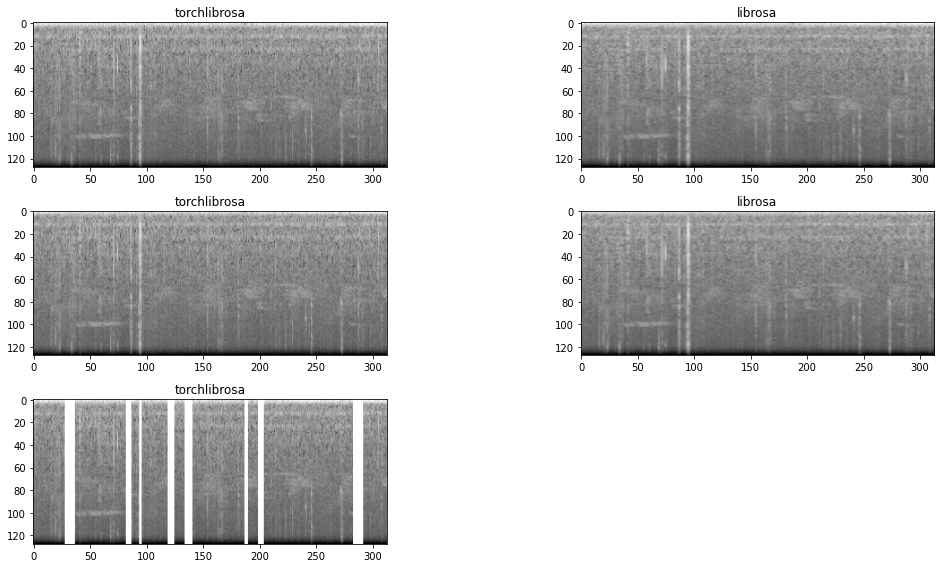

In [6]:
idx = 1054

img_torchlibrosa, img_librosa = get_valid_mel(idx, transform=False)

plt.figure(figsize=(16, 8))

plt.subplot(3, 2, 1)
plt.imshow(img_torchlibrosa, cmap="gray")
plt.title("torchlibrosa")


plt.subplot(3, 2, 2)
plt.imshow(img_librosa, cmap="gray")
plt.title("librosa")


img_torchlibrosa_, img_librosa_ = get_valid_mel(idx, transform=True)

plt.subplot(3, 2, 3)
plt.imshow(img_torchlibrosa_, cmap="gray")
plt.title("torchlibrosa")


plt.subplot(3, 2, 4)
plt.imshow(img_librosa_, cmap="gray")
plt.title("librosa")


img_torchlibrosa_, img_librosa_ = get_valid_mel(idx, spec=True)

plt.subplot(3, 2, 5)
plt.imshow(img_torchlibrosa_, cmap="gray")
plt.title("torchlibrosa")


plt.tight_layout()

In [ ]:
# img_torchlibrosa, img_librosa = get_valid_mel(984)

# plt.figure(figsize=(16, 8))

# plt.subplot(2, 2, 1)
# plt.imshow(img_torchlibrosa, cmap="gray")
# plt.title("torchlibrosa")


# plt.subplot(2, 2, 2)
# plt.imshow(img_librosa, cmap="gray")
# plt.title("librosa")


# transform = album.Compose([album.CLAHE(p=1.0, clip_limit=5, tile_grid_size=(4, 1))])
# img_torchlibrosa_ = ((img_torchlibrosa - img_torchlibrosa.min()) / (img_torchlibrosa.max() - img_torchlibrosa.min()) * 255).astype(np.uint8)
# img_torchlibrosa_ = transform(image=img_torchlibrosa_)["image"]
# plt.subplot(2, 2, 3)
# plt.imshow(img_torchlibrosa_, cmap="gray")
# plt.title("torchlibrosa")

# plt.tight_layout()

In [7]:
valid_df[valid_df["birds"] != "nocall"].head(800)

,row_id,site,audio_id,seconds,birds
0,11254_COR_5,COR,11254,5,rubwre1
2,11254_COR_15,COR,11254,15,rubwre1
4,11254_COR_25,COR,11254,25,rubwre1
27,11254_COR_140,COR,11254,140,obnthr1
28,11254_COR_145,COR,11254,145,obnthr1
...,...,...,...,...,...
1866,51010_SSW_335,SSW,51010,335,balori
1867,51010_SSW_340,SSW,51010,340,balori grycat
1868,51010_SSW_345,SSW,51010,345,grycat
1869,51010_SSW_350,SSW,51010,350,rewbla


In [55]:
train_df.head(3)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032


In [159]:
example_noise, _ = librosa.load(
    "../data/processed/noise/train_soundscape_nocall.wav",
    sr=const.TARGET_SAMPLE_RATE,
)
water_noise, _ = librosa.load(
    "../data/processed/noise/freesound_water_noise.wav",
    sr=const.TARGET_SAMPLE_RATE,
)
bus_noise, _ = librosa.load(
    "../data/processed/noise/freesound_bus_noise.wav",
    sr=const.TARGET_SAMPLE_RATE,
)
walk_noise, _ = librosa.load(
    "../data/processed/noise/freesound_walk_noise.wav",
    sr=const.TARGET_SAMPLE_RATE,
)
rain_noise, _ = librosa.load(
    "../data/processed/noise/freesound_rain_noise.wav",
    sr=const.TARGET_SAMPLE_RATE,
)
motorcycle_noise, _ = librosa.load(
    "../data/processed/noise/freesound_motorcycle_noise.wav",
    sr=const.TARGET_SAMPLE_RATE,
)
speaking_noise, _ = librosa.load(
    "../data/processed/noise/freesound_speaking_noise.wav",
    sr=const.TARGET_SAMPLE_RATE,
)
random_noise, _ = librosa.load(
    "../data/processed/noise/freesound_random_noise.wav",
    sr=const.TARGET_SAMPLE_RATE,
)
pink_noise, _ = librosa.load(
    "../data/processed/noise/pink_noise.wav",
    sr=const.TARGET_SAMPLE_RATE,
)

noise_dict = {
    "nocall": example_noise,
    "water": water_noise,
    "bus": bus_noise,
    "walk": walk_noise,
    "rain": rain_noise,
    "motorcycle": motorcycle_noise,
    "speaking": speaking_noise,
    "random": random_noise,
    "pink": pink_noise,
}

In [167]:
def add_noise(wave, noise_info_dict, m):
    rms = np.sqrt(np.mean(np.square(wave)))

    rand = np.random.rand()
    for noise_name in noise_info_dict:
        noise_threshhold = noise_info_dict[noise_name]
        noise_wave = noise_dict[noise_name]
        if rand >= noise_threshhold[0] and rand < noise_threshhold[1]:
            start = np.random.randint(len(noise_wave) - const.TARGET_SAMPLE_RATE * 5)
            noise_wave = noise_wave[start : start + const.TARGET_SAMPLE_RATE * 5].astype(np.float32)
            noise_rms = np.sqrt(np.mean(np.square(noise_wave)))

            wave = (wave * noise_rms) + (noise_wave * rms) * m

    return wave


def get_train_mel(idx, noise=True, transform=False, m=2.0):
    pl = train_df.loc[idx, "primary_label"]
    filename = train_df.loc[idx, "filename"]

    path = glob.glob(f"../data/input/train_short_audio/{pl}/{filename}")[0]
    y, sr = librosa.load(path, sr=const.TARGET_SAMPLE_RATE)
    
    y_ = y[: sr * 5]
    
    if noise:
        y_ = add_noise(y_, {"random": [0.0, 1.0]}, m=m)
        rms_added_noise = np.sqrt(np.mean(np.square(y_), axis=-1))
    
    if transform:
        audio_transforms = audio.Compose([
            audio.Gain(p=1.0),
#             audio.Shift(p=1.0),
#             audio.AddGaussianSNR(p=1.0)
        ])
        y_ = audio_transforms(
            samples=y_,
            sample_rate=const.TARGET_SAMPLE_RATE
        )

    img_torchlibrosa = wave2mel(y_, "torchlibrosa")
    img_librosa = wave2mel(y_, "librosa")

    return img_torchlibrosa, img_librosa

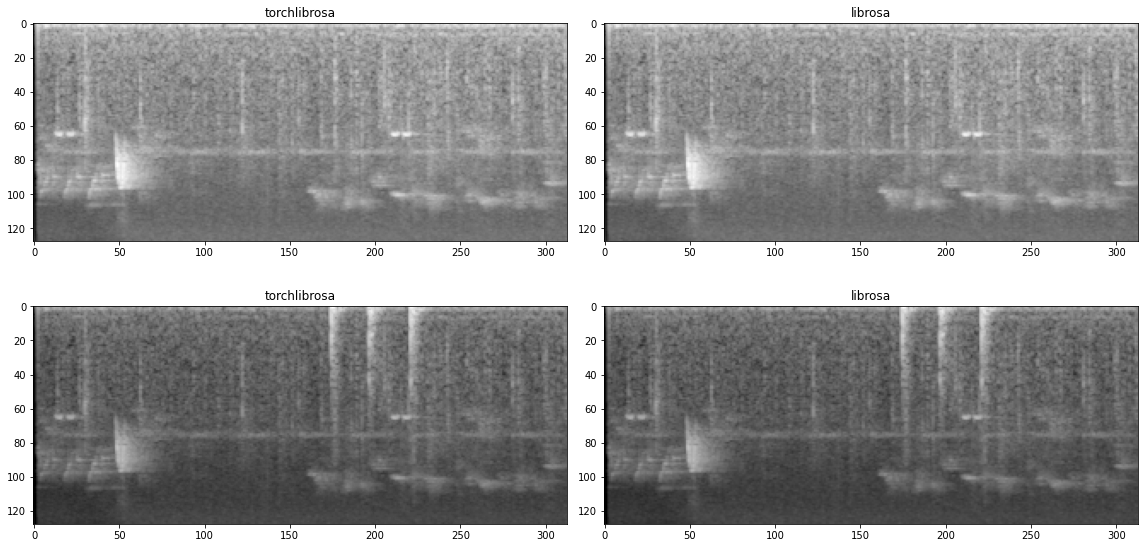

In [168]:
idx = 5

img_torchlibrosa, img_librosa = get_train_mel(idx, noise=False, transform=False)

plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.imshow(img_torchlibrosa, cmap="gray")
plt.title("torchlibrosa")


plt.subplot(2, 2, 2)
plt.imshow(img_librosa, cmap="gray")
plt.title("librosa")


img_torchlibrosa_, img_librosa_ = get_train_mel(idx, transform=True, m=2.0)

plt.subplot(2, 2, 3)
plt.imshow(img_torchlibrosa_, cmap="gray")
plt.title("torchlibrosa")


plt.subplot(2, 2, 4)
plt.imshow(img_librosa_, cmap="gray")
plt.title("librosa")


plt.tight_layout()

In [11]:
AUDIO_DIR = Path("../data/input/train_soundscapes")
DEVICE = "cuda"

cfg = dh.load("../logs/exp_096_20210515042121_0.636/config.yml")
cfg.data.valid.loader.batch_size = 8

valid_df["file_id"] = valid_df["audio_id"].astype(str) + "_" + valid_df["site"]
p = r"^(.+)_\d+.ogg"
all_test_audio = os.listdir(AUDIO_DIR)
file_id2fname = {re.search(p, f).group(1): f for f in all_test_audio if re.search(p, f)}
valid_df["file_name"] = valid_df["file_id"].map(file_id2fname)

In [176]:
class conf:
    duration = 5
    sampling_rate = 32_000
    n_fft = 2048
    hop_length = 512
    n_mels = 128
    fmin = 20
    fmax = sampling_rate // 2
    power = 2.0
    samples = sampling_rate * duration


class CustomTestDataset(Dataset):
    def __init__(self, df, cfg):
        super().__init__()
        self.cfg = cfg
        self.filenames = df["file_name"].values
        self.seconds = df["seconds"].values
#         self.transforms = get_transforms(cfg.transforms)
        self.y = None
        self.prior_filename = None

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        seconds = self.seconds[idx]
        path_name = str(AUDIO_DIR / filename)
        
        if filename == self.prior_filename:
            y = self.y
        else:
            y, sr = librosa.load(path_name, sr=conf.sampling_rate)
            self.y = y
            self.prior_filename = filename

        start_index = conf.sampling_rate * (seconds - 5)
        end_index = conf.sampling_rate * seconds
        y = y[start_index:end_index].astype(np.float32)

        return y

In [177]:
valid_dataset = CustomTestDataset(valid_df, cfg.data.valid)
test_loader = DataLoader(valid_dataset, **cfg.data.valid.loader)

for i, images in enumerate(test_loader):
    if type(images) == dict:
        for k, v in images.items():
            images[k] = v.to(DEVICE)
    else:
        images = images.to(DEVICE)
    break


# feature_extractor = torch.nn.Sequential(
#     Spectrogram(
#         n_fft=2048,
#         hop_length=512,
#         win_length=None,
#         window="hann",
#         center=True,
#         pad_mode="reflect",
#         freeze_parameters=True,
#     ),
#     LogmelFilterBank(
#         sr=32_000,
#         n_fft=2048,
#         n_mels=128,
#         fmin=20,
#         fmax=16_000,
#         ref=1.0,
#         amin=1e-10,
#         top_db=None,
#         freeze_parameters=True,
#     )
# ).to(DEVICE)

# bn0 = nn.BatchNorm2d(128).to(DEVICE)

# images_ = feature_extractor(images)
# images_ = images_.transpose(1, 3)
# images_ = bn0(images_)
# images_ = images_.transpose(1, 3)

# torch.save(images_, 'batch_image_sample.pt')

In [66]:
images = torch.load('batch_image_sample.pt').to(DEVICE)
images.shape

torch.Size([8, 1, 313, 128])

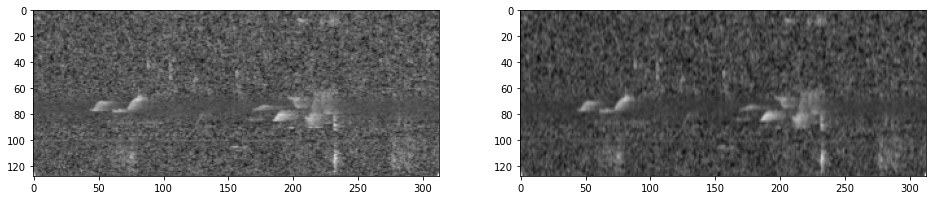

In [84]:
import kornia.augmentation as aug

idx = 2

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[idx, 0, :, :].transpose(0, 1).cpu().detach().numpy(), cmap="gray")

plt.subplot(1, 2, 2)
transform = aug.GaussianBlur((3, 3), (0.1, 3.0), p=1.)
images_ = transform(images)

plt.imshow(images_[idx, 0, :, :].transpose(0, 1).cpu().detach().numpy(), cmap="gray")